In [36]:
# imports the necessary libraries for the project
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19
from IPython.display import Image, display

In [37]:
# Define the paths for the base image and style reference image
base_image_path = "/base_image.jpg"
style_reference_image_path = "/style_image.jpg"

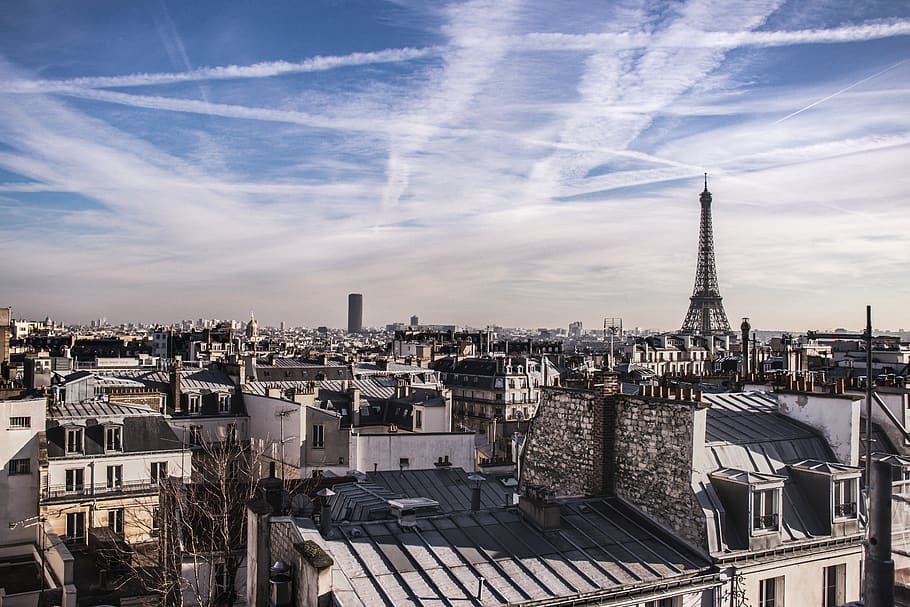

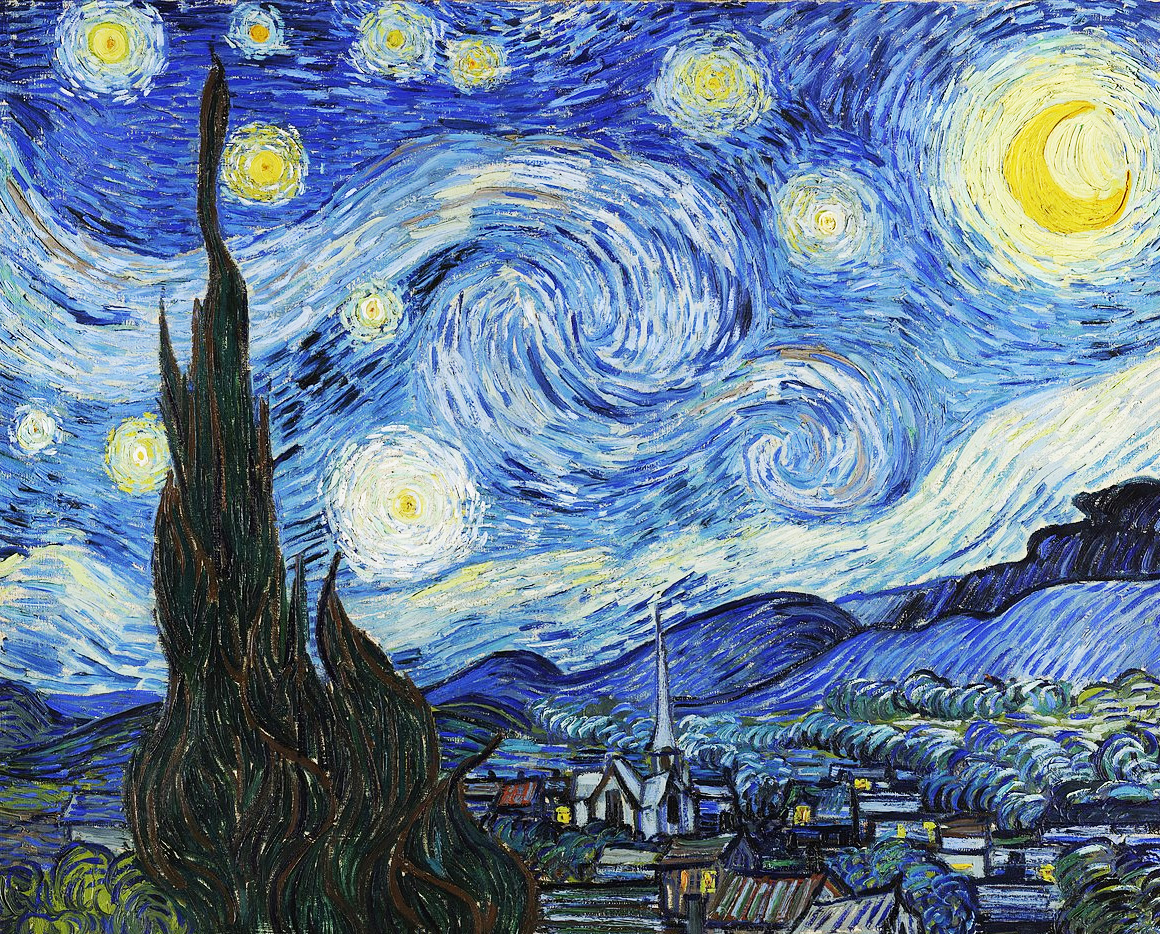

In [38]:
# Display the base image and style reference image
display(Image(base_image_path))
display(Image(style_reference_image_path))

In [39]:
# Define the desired dimensions for the generated image
width, height = keras.utils.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

In [40]:
# Preprocess the image
def preprocess_image(image_path):
    img = keras.utils.load_img(image_path, target_size=(img_nrows, img_ncols))
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)

In [41]:
# Convert the generated image back to its original format
def deprocess_image(x):
    x = x.reshape((img_nrows, img_ncols, 3))
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

In [42]:
# Calculate the Gram matrix for a given tensor
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

In [43]:
# Calculate the style loss between a style image and a combination image
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels**2) * (size**2))

In [44]:
# Calculate the content loss between a base image and a combination image
def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))

In [45]:
# Calculate the total variation loss for a given image
def total_variation_loss(x):
    a = tf.square(x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :])
    b = tf.square(x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :])
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [46]:
# Load the VGG19 model pre-trained on ImageNet
model = vgg19.VGG19(weights="imagenet", include_top=False)

In [47]:
# Create a dictionary mapping layer names to their outputs
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

In [48]:
# Build a feature extraction model using VGG19
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

In [49]:
# Define the style layer names and content layer name
style_layer_names = ["block1_conv1", "block2_conv1", "block3_conv1", "block4_conv1", "block5_conv1"]
content_layer_name = "block5_conv2"

In [50]:
# Set the weights for loss calculation
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

In [51]:
# Compute the total loss for the combination image
def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat([base_image, style_reference_image, combination_image], axis=0)
    features = feature_extractor(input_tensor)
    loss = tf.zeros(shape=())
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(base_image_features, combination_features)
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

In [52]:
# Compute the loss and gradients for the combination image
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

In [53]:
# Set the optimizer with a learning rate decay
optimizer = keras.optimizers.SGD(keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96))

In [54]:
# Preprocess the base image, style reference image, and combination image
base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

In [55]:
# Set the prefix for saving the generated images
result_prefix = "generated"

# Set the number of iterations for optimization
iterations = 400

# Perform the style transfer optimization loop
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(combination_image, base_image, style_reference_image    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 100 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = deprocess_image(combination_image.numpy())
        fname = result_prefix + "_at_iteration_%d.png" % i
        keras.utils.save_img(fname, img)

Iteration 100: loss=11024.58
Iteration 200: loss=8518.81
Iteration 300: loss=7573.99
Iteration 400: loss=7063.51


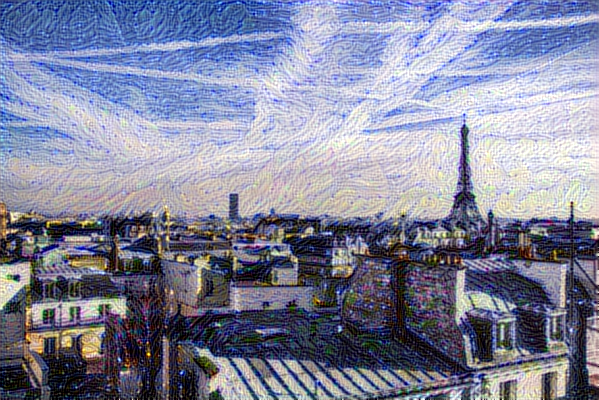

In [56]:
# display the final generated image
display(Image(result_prefix + "_at_iteration_400.png"))